# Проект: предсказание оттока клиентов

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Создание-дополнительных-переменных" data-toc-modified-id="Создание-дополнительных-переменных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Создание дополнительных переменных</a></span></li><li><span><a href="#Разделение-данных" data-toc-modified-id="Разделение-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Разделение данных</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Тестирование-фунции" data-toc-modified-id="Тестирование-фунции-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование фунции</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Описание проекта

    Заказчик хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
    
    Постановка задачи: разработка модели, которая на базе представленных данных, способная спрогнозировать возможный отток с точностью 0.75 < AUC-ROC ≤ 0.88

## Подготовка данных

In [2]:
#используемые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMRegressor
from sklearn import datasets

import warnings
warnings.filterwarnings("ignore")

In [3]:
from io import BytesIO
import requests
spreadsheet_id = 'имя файла'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
contact = pd.read_csv(BytesIO(r.content))
contact

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60


Загружен фаил _contact_ с информацией о договорах клиентов с заказчиком.

In [4]:
from io import BytesIO
import requests
spreadsheet_id = 'имя файла'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
internet = pd.read_csv(BytesIO(r.content))
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


Загружен фаил _internet_ с информацией об услугах, которыми пользуются клиенты.

In [5]:
from io import BytesIO
import requests
spreadsheet_id = 'имя файла'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
personal = pd.read_csv(BytesIO(r.content))
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


Загружен фаил _personal_ с персональной информацией о клиентах.

In [6]:
from io import BytesIO
import requests
spreadsheet_id = 'имя файла'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
phone = pd.read_csv(BytesIO(r.content))
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


Загружен фаил _phone_ с информацией о телефонных услугах, которыми пользуются клиенты.

In [7]:
#заполняем пропуски медианным значением
print(contact.info())
contact['TotalCharges'] = contact['TotalCharges'].fillna(contact['TotalCharges'].median())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None


In [8]:
#перевод в нужный тип данных для дат
contact['BeginDate'] = pd.to_datetime(contact['BeginDate'])
contact['EndDate'] = pd.to_datetime(contact['EndDate'], errors='coerce')

In [9]:
#объединение данных
data_all = contact.merge(personal)
data_all = data_all.merge(internet, how='left')
data_all = data_all.merge(phone, how='left')

print(data_all.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             1869 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: datetime64[ns](2), float64(2), int64(1), object(

Создаем сводную таблицу на базе загруженных таблиц.

In [10]:
#заполнение пропусков
colomns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
data_all[colomns] = data_all[colomns].fillna('No')

print(data_all.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             1869 non-null datetime64[ns]
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
MultipleLines       7043 non-null object
dtypes: datetime64[ns](2), float64(2), int64(1), object(

In [11]:
#так как данные представлены до 1 февраля 2020 года, примем эту дату за конечную
data_final='2020-02-01'
data_final = pd.to_datetime(data_final, format='%Y-%m-%d')
print(data_final)

2020-02-01 00:00:00


**Вывод:**

Предобработка данных завершена: пропуски заполнены, данные приведены к нужному типу, создан единный датафрейм со всеми имеющимся данными.

## Создание дополнительных переменных

In [12]:
#создание новой переменной и таргета
data_all['EndDate_lifetime'] = data_all['EndDate']
data_all['EndDate_lifetime'] = data_all['EndDate_lifetime'].fillna(data_final)
data_all['lifetime'] = data_all['EndDate_lifetime'] - data_all['BeginDate']
data_all['target'] = data_all['EndDate']

data_all['target'] = data_all['target'].fillna(0)
filter = data_all['target']==0
data_all['target'].where(filter, 1, inplace=True)

display(data_all.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate_lifetime,lifetime,target
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,Yes,No,No,No,No,No,2020-02-01,31 days,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,...,Yes,No,Yes,No,No,No,No,2020-02-01,1036 days,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,Yes,No,No,No,No,No,2019-12-01,61 days,1
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,Yes,No,Yes,Yes,No,No,No,2020-02-01,1371 days,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,No,No,2019-11-01,61 days,1


Для будущего моделирования использовать даты неудобно, поэтому конвертируем их в численные показатели - срок жизни клиента.
Для этого используем параметры _BeginDate_ и _EndDate_, вычитая одно из другого. 

Для выделения таргета используем показатель _EndDate_. Если имеется дата окончания договора, значит клиент уже покинул компанию. Если нет - на момент формирования исходных данных клиент был активен.

In [13]:
#для преобразования признаков из категориальных в численные используем прямое кодирование (OHE)
data_ohe = pd.get_dummies(data_all, drop_first=True, columns=['Type', 'PaymentMethod', 'gender', 'Partner' ,'Dependents', 'InternetService', 'OnlineSecurity',
                                                             'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                                                             'StreamingMovies', 'MultipleLines'])
data_all = data_all.join(data_ohe, lsuffix='_left')


С помощью прямого кодирования вместо категориальных данных (текста), получаем логический тип, более удобный для машинного обучения.

In [14]:
#удаляем дубли
data_all = data_all.drop(['Type', 'PaymentMethod', 'gender', 'Partner' , 'Dependents',  'InternetService', 'OnlineSecurity',
                                                             'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                                                             'StreamingMovies', 'MultipleLines'], axis=1)

In [15]:
print(data_all.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 37 columns):
customerID_left                          7043 non-null object
BeginDate_left                           7043 non-null datetime64[ns]
EndDate_left                             1869 non-null datetime64[ns]
PaperlessBilling_left                    7043 non-null object
MonthlyCharges_left                      7043 non-null float64
TotalCharges_left                        7043 non-null float64
SeniorCitizen_left                       7043 non-null int64
EndDate_lifetime_left                    7043 non-null datetime64[ns]
lifetime_left                            7043 non-null timedelta64[ns]
target_left                              7043 non-null object
customerID                               7043 non-null object
BeginDate                                7043 non-null datetime64[ns]
EndDate                                  1869 non-null datetime64[ns]
PaperlessBilling                     

Датафрейм зтал значительно больше, появились дубли. Также остались столбцы с датами, которые нам больше не нужны.

In [16]:
#удаляем дубли и ненужные столбцы
data_all = data_all.drop(['customerID_left', 'BeginDate_left', 'EndDate_left', 'PaperlessBilling_left', 'MonthlyCharges_left',
                         'TotalCharges_left', 'SeniorCitizen_left','lifetime_left', 'target_left', 'customerID', 
                          'BeginDate', 'EndDate', 'PaperlessBilling', 'EndDate_lifetime', 'EndDate_lifetime_left'], axis=1)

**Вывод**

Некоторые столбцы были удалены, потому что содержат лишнюю информацию, из-за чего понижается точность моделей. Например:
1. _customerID_ - не несет информации для моделирования
2. столбцы с датами (_BeginDate, EndDate_) - создан отдельный параметр _lifetime_, чтобы показать продолжительность отношений с клиентом
3. _PaperlessBilling_ - безналичный расчет, этот параметр не критичен, более того его отсутствие повышает точность моделей

In [17]:
print(data_all.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
MonthlyCharges                           7043 non-null float64
TotalCharges                             7043 non-null float64
SeniorCitizen                            7043 non-null int64
lifetime                                 7043 non-null timedelta64[ns]
target                                   7043 non-null object
Type_One year                            7043 non-null uint8
Type_Two year                            7043 non-null uint8
PaymentMethod_Credit card (automatic)    7043 non-null uint8
PaymentMethod_Electronic check           7043 non-null uint8
PaymentMethod_Mailed check               7043 non-null uint8
gender_Male                              7043 non-null uint8
Partner_Yes                              7043 non-null uint8
Dependents_Yes                           7043 non-null uint8
InternetService_Fiber optic              7043 non-null uint8
InternetService_No      

Проверяем датафрейм после удаления лишних параметров. У параметра _target_ необходимо поменять тип данных. Также перевести параметр _lifetime_ из наносекунд в дни.

In [18]:
#приведение данных в нужный тип (lifetime в наносекундах)
data_all['target'] = data_all['target'].astype('int')

data_all['lifetime'] = pd.to_numeric(data_all['lifetime'])
data_all['lifetime'] = data_all['lifetime']/(8.62*10**13)

In [19]:
display(data_all.head())

,MonthlyCharges,TotalCharges,SeniorCitizen,lifetime,target,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,29.85,29.85,0,31.071926,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,56.95,1889.50,0,1038.403712,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
2,53.85,108.15,0,61.141531,1,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
3,42.30,1840.75,0,1374.180974,0,1,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
4,70.70,151.65,0,61.141531,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


Проверяем датафрейм после смены типа данных.

In [20]:
#проверка параметров на корреляцию
data_corr = data_all.corr()
display(data_corr)

,MonthlyCharges,TotalCharges,SeniorCitizen,lifetime,target,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
MonthlyCharges,1.000000,0.650864,0.220173,0.247754,0.193356,0.004904,-0.074681,0.030550,0.271625,-0.377437,...,-0.113890,0.787066,-0.763557,0.296594,0.441780,0.482692,0.338304,0.629603,0.627429,0.490434
TotalCharges,0.650864,1.000000,0.102652,0.825394,-0.199037,0.170649,0.356226,0.182745,-0.059971,-0.294814,...,0.063593,0.361045,-0.374706,0.412091,0.509607,0.522374,0.432329,0.515279,0.519884,0.468705
SeniorCitizen,0.220173,0.102652,1.000000,0.016514,0.150889,-0.046262,-0.117000,-0.024135,0.171718,-0.153477,...,-0.211185,0.255338,-0.182742,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176,0.142948
lifetime,0.247754,0.825394,0.016514,1.000000,-0.352673,0.202650,0.558544,0.233032,-0.208465,-0.233755,...,0.159766,0.019574,-0.038951,0.327203,0.360238,0.360602,0.324238,0.279657,0.286007,0.331833
target,0.193356,-0.199037,0.150889,-0.352673,1.000000,-0.177820,-0.302253,-0.134302,0.301919,-0.091683,...,-0.164221,0.308020,-0.227890,-0.171226,-0.082255,-0.066160,-0.164674,0.063228,0.061382,0.040102
Type_One year,0.004904,0.170649,-0.046262,0.202650,-0.177820,1.000000,-0.289510,0.067589,-0.109130,-0.000116,...,0.068368,-0.076324,0.038004,0.100162,0.083722,0.102495,0.095775,0.061612,0.064926,-0.003794
Type_Two year,-0.074681,0.356226,-0.117000,0.558544,-0.302253,-0.289510,1.000000,0.173265,-0.282138,-0.004705,...,0.204613,-0.211526,0.218278,0.191773,0.111400,0.165096,0.240824,0.072049,0.073960,0.106253
PaymentMethod_Credit card (automatic),0.030550,0.182745,-0.024135,0.233032,-0.134302,0.067589,0.173265,1.000000,-0.373322,-0.286049,...,0.060267,-0.050077,0.001030,0.115721,0.090785,0.111554,0.117272,0.040433,0.048575,0.060048
PaymentMethod_Electronic check,0.271625,-0.059971,0.171718,-0.208465,0.301919,-0.109130,-0.282138,-0.373322,1.000000,-0.387372,...,-0.150642,0.336410,-0.284917,-0.112338,-0.000408,-0.003351,-0.114839,0.144626,0.137966,0.083618
PaymentMethod_Mailed check,-0.377437,-0.294814,-0.153477,-0.233755,-0.091683,-0.000116,-0.004705,-0.286049,-0.387372,1.000000,...,0.059071,-0.306834,0.321361,-0.080798,-0.174164,-0.187373,-0.085509,-0.247742,-0.250595,-0.227206


**Вывод:**

Коэффициенты корреляции показывают насколько параметры зависят друг от друга. Если коэффициент корреляции между параметрами высокий (>0.8), при дальшейшем обучении это может привести к снижению точности модели или ее переобучению. В оставшихся у нас данных, таких высоких коэффициентов нет.

**Вывод**

Данные почищены, заполнены пропуски, выделены признаки для будущего моделирования, также созданы новый признак и _target_.

## Разделение данных

In [21]:
#разделение данных на основную и тестовую выборки
data_train, data_test = train_test_split(data_all, test_size=0.2, random_state=12345)

features = data_train.drop(['target'], axis=1)
target = data_train['target']

In [22]:
data_train.info()
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 1580 to 4578
Data columns (total 22 columns):
MonthlyCharges                           5634 non-null float64
TotalCharges                             5634 non-null float64
SeniorCitizen                            5634 non-null int64
lifetime                                 5634 non-null float64
target                                   5634 non-null int32
Type_One year                            5634 non-null uint8
Type_Two year                            5634 non-null uint8
PaymentMethod_Credit card (automatic)    5634 non-null uint8
PaymentMethod_Electronic check           5634 non-null uint8
PaymentMethod_Mailed check               5634 non-null uint8
gender_Male                              5634 non-null uint8
Partner_Yes                              5634 non-null uint8
Dependents_Yes                           5634 non-null uint8
InternetService_Fiber optic              5634 non-null uint8
InternetService_No            

Проверяем соотношение выборок, чтобы убедится, что все правильно.

In [23]:
features_test = data_test.drop(['target'], axis=1)
target_test = data_test['target']

**Так как далее будет использована кросс-валидация, поэтому выделяем только тестовую выборку.**

In [24]:
#разделение данных для градиентного бустинга
data_train2, data_valid = train_test_split(data_train, test_size=0.25, random_state=12345)
print(data_train2.shape)
print(data_valid.shape)


(4225, 22)
(1409, 22)


In [25]:
#выделяем таргет в отдельную выборку и готовим признаки для дальнейшего обучения
features_train = data_train2.drop(['target'], axis=1)
target_train = data_train2['target']

features_valid = data_valid.drop(['target'], axis=1)
target_valid = data_valid['target']

**Вывод**

Составлены выборки для дальнейшего моделирования. Также была создана тестовая выборка.

## Борьба с дисбалансом

In [26]:
print(data_all['target'].value_counts())

0    5174
1    1869
Name: target, dtype: int64


Дисбаланс присутствует, только 26,5% клиентов от выборки остались в компании. В данном случае имеет смысл провести увеличение выборки, чтобы положительных объектов стало больше. После этого модель должна лучше предсказывать положительные ответы, соответственно полнота модели должна увеличится.

In [27]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features, target, 2)

print(features_upsampled.shape)
print(target_upsampled.shape)

(7124, 21)
(7124,)


**Вывод**

Дисбаланс для обучающей выборки устранен.

## Обучение моделей

Для обучения моделей используется метод кросс-валидации, как более надежный. Также, для сравнения, посмотрим градиентный бустинг LGBM.

In [28]:
#модель решающего дерева
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=12) 

score_tree = cross_val_score(model_tree, 
                         features_upsampled, target_upsampled, 
                         cv=15,
                       scoring='roc_auc')

final_score_tree =  (abs(score_tree).sum())/len(score_tree)
print('AUC-ROC:', final_score_tree)

AUC-ROC: 0.9030916500014922


In [29]:
#модель случайного леса
model_forest = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=19)

scores_forest = cross_val_score(model_forest, 
                         features_upsampled, target_upsampled, 
                         cv=50, 
                         scoring='roc_auc')
final_score_forest =  (abs(scores_forest).sum())/len(scores_forest)
print('AUC-ROC:', final_score_forest)

AUC-ROC: 0.9736314061537592


In [30]:
#логистическая регрессия
model_logistic = LogisticRegression(random_state=12345, solver='liblinear')

scores_logistic = cross_val_score(model_logistic, 
                         features_upsampled, target_upsampled, 
                         cv=5, 
                         scoring='roc_auc')
final_score_logistic =  (abs(scores_logistic).sum())/len(scores_logistic)
print('AUC-ROC:', final_score_logistic)

AUC-ROC: 0.8431011149036169


In [31]:
#градиентный бустинг LGBM
model_lgbm = LGBMRegressor(n_estimators=50, max_depth=30, learning_rate=0.2, boosting_type='gbdt')
model_lgbm.fit(features_train, target_train)
prediction_lgbm = model_lgbm.predict(features_valid)
print('AUC-ROC:', roc_auc_score(target_valid, prediction_lgbm))

AUC-ROC: 0.873489677225513


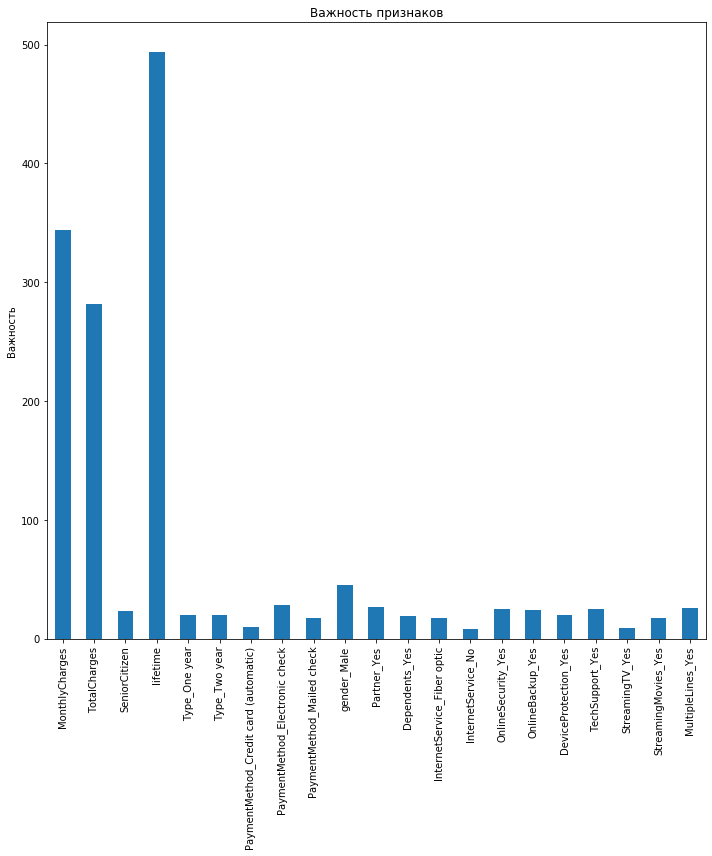

In [32]:
#посмотрим, какие параметры влияют на модель сильнее всего
skl_iris_imp = pd.Series(model_lgbm.feature_importances_,
                         data_all.drop(['target'], axis=1).columns)

fig, ax = plt.subplots(figsize=(10,12))
skl_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Из графика выше явно видно какие показатели влияют на модель больше всего: _MonthlyCharges_, _TotalCharges_, _lifetime_.

**Вывод**

Из всех используемых моделей лучший результат показала модель случайного леса (AUC-ROC: 0.97).

## Тестирование фунции

In [33]:
scores_forest_test = cross_val_score(model_forest, 
                         features_test, target_test, 
                         cv=50, 
                         scoring='roc_auc')
final_score_forest_test =  (abs(scores_forest_test).sum())/len(scores_forest_test)
print('AUC-ROC:', final_score_forest_test)

AUC-ROC: 0.8439353741496598


**Вывод**

Проверка на тестовой выборке не показывает такого же хорошего результата. Скорей всего, это связано с тем, что для обучающей выборки был устранен дисбаланс классов, а в тестовой выборке он остался. Очевидно, для модели решающего дерева будет похожая картина. Проверим на тестовой выборке модель градиентного бустинга.

In [34]:
prediction_lgbm_test = model_lgbm.predict(features_test)
print('AUC-ROC:', roc_auc_score(target_test, prediction_lgbm_test))

AUC-ROC: 0.8838076696467455


**Вывод**

Модель градиентного бустинга на тестовой выборке дает необходимую точность. Следовательно, именно ее стоит использовать для дальнейшего прогноза.

## Вывод

По данной работе можно сделать следующие выводы:
1. Была проведена предобработка данных: перевод в нужный тип, устранение пропусков.
2. Для категориальных признаков использовано прямое кодирование (OHE)
3. Были выделены, а также сформированы новые признаки для моделирования
4. При моделировании на тестовой выборке самую высокую точность показала модель случайного леса, но на тестовой выборке точность выше у LGBM
5. Как итог, рекомендуемая модель с самой высокой точностью - LGBM

Ура!＼(￣▽￣)／